# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize as imresize
import datetime
import os

import imageio # using as an alternative of imread as it is deprecated
from PIL import Image # using as an alternative of imread as it is deprecated
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loadthe data from gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzip the dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Project_data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        print("")
                        image = imresize(image,(84,84)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = 104 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = 117 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = 123 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = imresize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                                        
                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [18]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,GlobalAveragePooling2D,ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D,Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 1. Model Conv3D

In [ ]:
#write your model here
Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


2022-12-11 14:28:48.904413: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-11 14:28:48.904483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 84, 128)   5

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7263 - categorical_accuracy: 0.6917
Epoch 1: saving model to model_init_2022-12-1301_29_53.471139/model-00001-0.72633-0.69170-0.75147-0.75000.h5
11/11 [==============================] - 62s 6s/step - loss: 0.7263 - categorical_accuracy: 0.6917 - val_loss: 0.7515 - val_categorical_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6295 - categorical_accuracy: 0.7668
Epoch 2: saving model to model_init_2022-12-1301_29_53.471139/model-00002-0.62951-0.76680-0.55618-0.75000.h5
11/11 [==============================] - 66s 7s/step - loss: 0.6295 - categorical_accuracy: 0.7668 - val_loss: 0.5562 - val_categorical_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.7497 - categorical_accuracy: 0.7352
Epoch 3: saving model to model_init_2022-12-1301_29_53.471139/model-00003-0.74968-0.73518-0.61255-0.72222.h5
11/11 [========

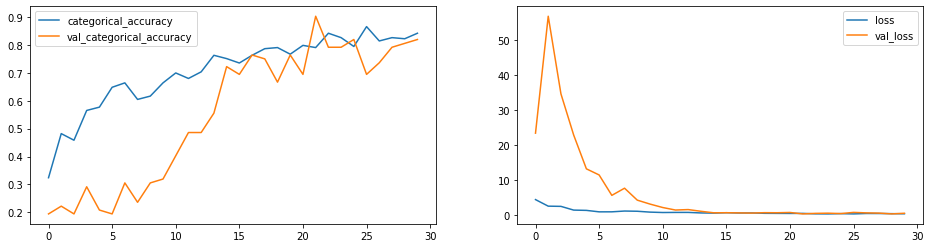

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 2. Model Conv3D

In [ ]:
input_shape = 18,84,84,3
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 82, 82, 32)    2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 41, 41, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 39, 39, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 19, 19, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 69312)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 11500.8916 - categorical_accuracy: 0.1779
Epoch 00001: saving model to model_init_2022-12-1114_28_45.745083/model-00001-11500.89160-0.17787-1.61476-0.22222.h5
11/11 [==============================] - 45s 4s/step - loss: 11500.8916 - categorical_accuracy: 0.1779 - val_loss: 1.6148 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.1700
Epoch 00002: saving model to model_init_2022-12-1114_28_45.745083/model-00002-1.61553-0.16996-1.61005-0.18056.h5
11/11 [==============================] - 47s 5s/step - loss: 1.6155 - categorical_accuracy: 0.1700 - val_loss: 1.6101 - val_categorical_accuracy: 0.1806 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.2016
Epoch 00003: saving model to model_init_2022-12-1114_28_45.745083/model-00003-1.61029-0.20158-1.61266-0.18056.h5

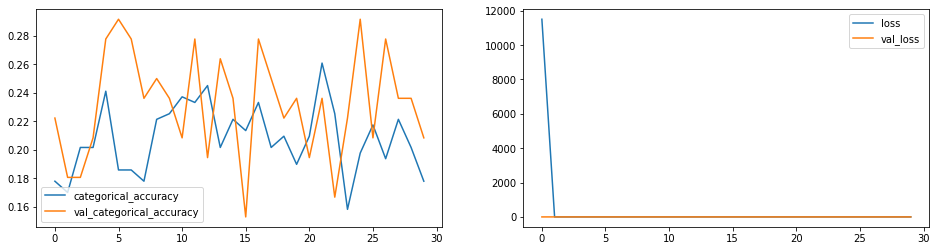

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 3. Model Conv3D

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3,3) , activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 2, 2)))

model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))


ValueError: Exception encountered when calling layer "conv3d_9" (type Conv3D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv3d_9/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, conv3d_9/Conv3D/ReadVariableOp)' with input shapes: [?,2,19,19,128], [3,3,3,128,256].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 19, 19, 128), dtype=float32)

### 4. Model Conv3D

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 16, 82, 82, 32)    2624      
                                                                 
 conv3d_11 (Conv3D)          (None, 14, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 conv3d_12 (Conv3D)          (None, 5, 38, 38, 128)    221312    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 19, 19, 128)   0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 17, 17, 256)   

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1291324.1250 - categorical_accuracy: 0.1976
Epoch 00001: saving model to model_init_2022-12-1114_28_45.745083/model-00001-1291324.12500-0.19763-2.66316-0.15278.h5
11/11 [==============================] - 46s 4s/step - loss: 1291324.1250 - categorical_accuracy: 0.1976 - val_loss: 2.6632 - val_categorical_accuracy: 0.1528 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.8114 - categorical_accuracy: 0.2095
Epoch 00002: saving model to model_init_2022-12-1114_28_45.745083/model-00002-1.81136-0.20949-1.74690-0.18056.h5
11/11 [==============================] - 42s 4s/step - loss: 1.8114 - categorical_accuracy: 0.2095 - val_loss: 1.7469 - val_categorical_accuracy: 0.1806 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.6468 - categorical_accuracy: 0.2530
Epoch 00003: saving model to model_init_2022-12-1114_28_45.745083/model-00003-1.64681-0.25296-1.61305-0.20

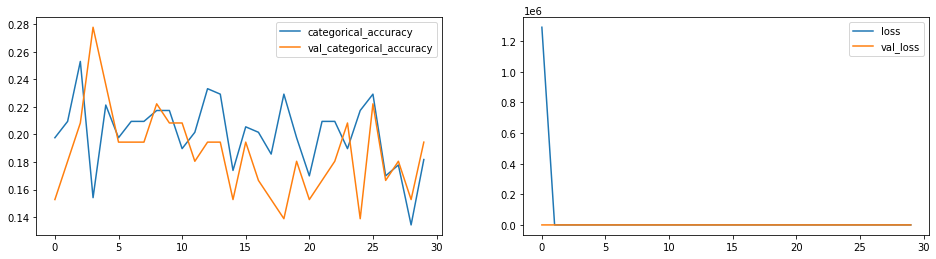

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 5. Model Conv3D

In [ ]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 82, 82, 32)    2624      
                                                                 
 conv3d_17 (Conv3D)          (None, 14, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 40, 40, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 7, 40, 40, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_18 (Conv3D)          (None, 5, 38, 38, 128)    221312    
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 5, 19, 19, 128)  

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 5.1335 - categorical_accuracy: 0.2688
Epoch 00001: saving model to model_init_2022-12-1114_28_45.745083/model-00001-5.13353-0.26877-112181.37500-0.19444.h5
11/11 [==============================] - 51s 5s/step - loss: 5.1335 - categorical_accuracy: 0.2688 - val_loss: 112181.3750 - val_categorical_accuracy: 0.1944 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.6950 - categorical_accuracy: 0.3478
Epoch 00002: saving model to model_init_2022-12-1114_28_45.745083/model-00002-2.69502-0.34783-7473.48779-0.38889.h5
11/11 [==============================] - 48s 5s/step - loss: 2.6950 - categorical_accuracy: 0.3478 - val_loss: 7473.4878 - val_categorical_accuracy: 0.3889 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.8180 - categorical_accuracy: 0.3874
Epoch 00005: saving model to model_init_2022-12-1114_28_45.745083/model-00005-1.31295-0.50198-192.82150-0.19

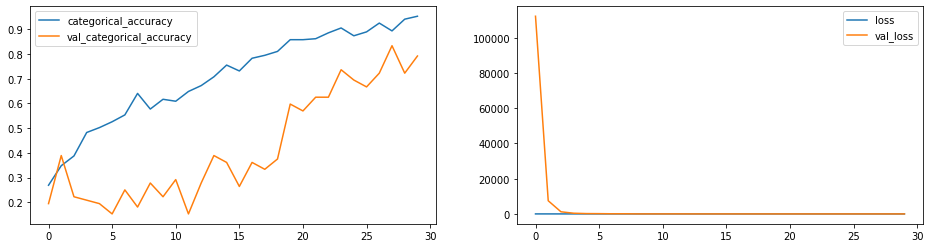

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 6. Model Conv3D

In [ ]:
input_shape=18,84,84,3
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 82, 82, 32)    2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 80, 80, 64)    55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 40, 40, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 40, 40, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 40, 40, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 5, 38, 38, 128)   

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 64
Epoch 1/30


2022-12-12 02:35:47.443992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 3.5726 - categorical_accuracy: 0.2174Source path =  /datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2022-12-1202_31_33.593754/model-00001-3.57255-0.21739-26081.55078-0.20833.h5
11/11 [==============================] - 46s 4s/step - loss: 3.5726 - categorical_accuracy: 0.2174 - val_loss: 26081.5508 - val_categorical_accuracy: 0.2083 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.7089 - categorical_accuracy: 0.3953
Epoch 00002: saving model to model_init_2022-12-1202_31_33.593754/model-00002-1.70889-0.39526-3661.17065-0.22222.h5
11/11 [==============================] - 42s 4s/step - loss: 1.7089 - categorical_accuracy: 0.3953 - val_loss: 3661.1707 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.6828 - categorical_accuracy: 0.4269
Epoch 00003: saving model to model_init_2022-12-1202_31_33.59

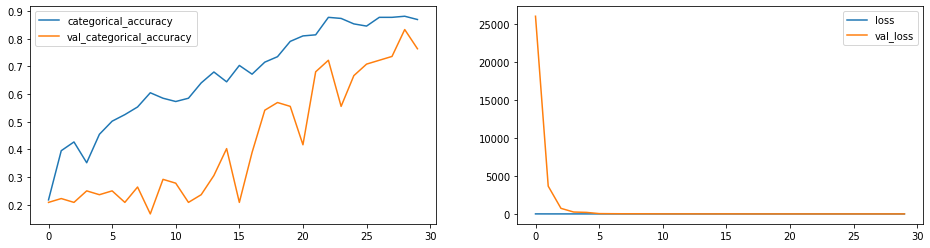

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 7. Model Conv3D

In [26]:
input_shape = 18,84,84,3
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [27]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 82, 82, 32)    2624      
                                                                 
 conv3d_9 (Conv3D)           (None, 14, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 7, 40, 40, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 7, 40, 40, 64)     0         
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 38, 38, 128)   

In [28]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 3.7756 - categorical_accuracy: 0.3874
Epoch 1: saving model to model_init_2022-12-1301_29_53.471139/model-00001-3.77556-0.38735-7224.72461-0.20833.h5
11/11 [==============================] - 64s 6s/step - loss: 3.7756 - categorical_accuracy: 0.3874 - val_loss: 7224.7246 - val_categorical_accuracy: 0.2083 - lr: 0.0100
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 2.1505 - categorical_accuracy: 0.4585
Epoch 2: saving model to model_init_2022-12-1301_29_53.471139/model-00002-2.15046-0.45850-1871.08203-0.22222.h5
11/11 [==============================] - 67s 7s/step - loss: 2.1505 - categorical_accuracy: 0.4585 - val_loss: 1871.0820 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 1.3922 - categorical_accuracy: 0.4664
Epoch 3: saving model to model_init_2022-12-1301_29_53.471139/model-00003-1.39215-0.46640-488.12250-0.30556.h5
11/11 [==

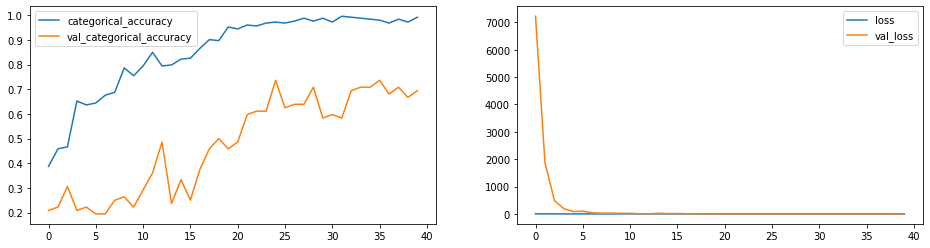

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 8. Model Conv3D

In [ ]:
input_shape = 18,84,84,3
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 82, 82, 32)    2624      
                                                                 
 conv3d_5 (Conv3D)           (None, 14, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 7, 40, 40, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 7, 40, 40, 64)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 5, 38, 38, 128)   

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 3.1775 - categorical_accuracy: 0.2806Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-12-1205_43_36.079496/model-00001-3.17745-0.28063-1910.31445-0.25000.h5
11/11 [==============================] - 68s 5s/step - loss: 3.1775 - categorical_accuracy: 0.2806 - val_loss: 1910.3145 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.1789 - categorical_accuracy: 0.3004
Epoch 2: saving model to model_init_2022-12-1205_43_36.079496/model-00002-2.17886-0.30040-830.65289-0.22222.h5
11/11 [==============================] - 57s 6s/step - loss: 2.1789 - categorical_accuracy: 0.3004 - val_loss: 830.6529 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.7875 - categorical_accuracy: 0.4190
Ep

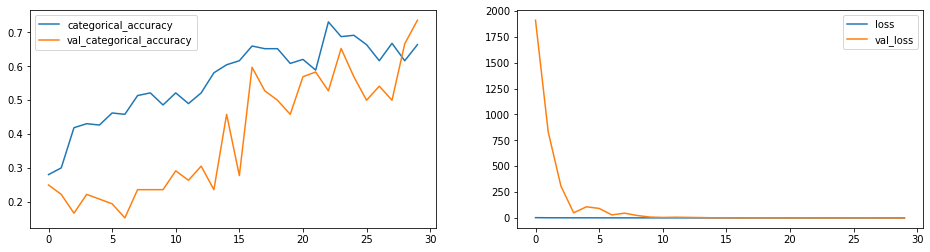

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 9. Model Timedistibuted Conv2D GRU

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 82, 82, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 41, 41, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 18, 41, 41, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 39, 39, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 19, 19, 64)  

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 2.1586 - categorical_accuracy: 0.3676
Epoch 1: saving model to model_init_2022-12-1205_43_36.079496/model-00001-2.15856-0.36759-2.37904-0.25000.h5
11/11 [==============================] - 63s 6s/step - loss: 2.1586 - categorical_accuracy: 0.3676 - val_loss: 2.3790 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.3511 - categorical_accuracy: 0.4704
Epoch 2: saving model to model_init_2022-12-1205_43_36.079496/model-00002-1.35111-0.47036-2.17067-0.23611.h5
11/11 [==============================] - 59s 6s/step - loss: 1.3511 - categorical_accuracy: 0.4704 - val_loss: 2.1707 - val_categorical_accuracy: 0.2361 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.2893 - categorical_accuracy: 0.4625
Epoch 3: saving model to model_init_2022-12-1205_43_36.079496/model-00003-1.28925-0.46245-2.43219-0.19444.h5
11/11 [================

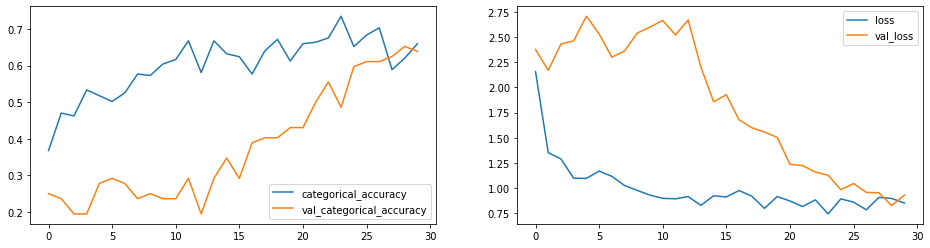

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 10. Model Timedistributed Conv2D GRU

In [ ]:
input_shape = 18,84,84,3
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 82, 82, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 41, 41, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 18, 41, 41, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 18, 41, 41, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 39, 39, 64)   18496     
 tributed)                                            

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 2.2609 - categorical_accuracy: 0.3399Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-12-1208_29_51.548856/model-00001-2.26089-0.33992-2.61878-0.19444.h5
11/11 [==============================] - 79s 6s/step - loss: 2.2609 - categorical_accuracy: 0.3399 - val_loss: 2.6188 - val_categorical_accuracy: 0.1944 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.4596 - categorical_accuracy: 0.4111
Epoch 2: saving model to model_init_2022-12-1208_29_51.548856/model-00002-1.45965-0.41107-2.59023-0.22222.h5
11/11 [==============================] - 80s 8s/step - loss: 1.4596 - categorical_accuracy: 0.4111 - val_loss: 2.5902 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.3674 - categorical_accuracy: 0.4545
Epoch 3: sav

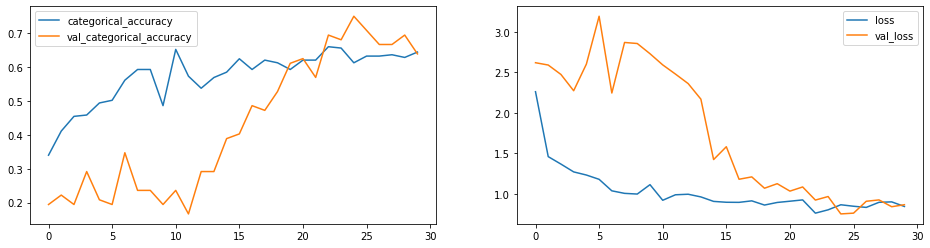

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 11. Model TimeDistributed Conv2D Dence

In [ ]:
input_shape = 18,84,84,3

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 18, 82, 82, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 41, 41, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 18, 41, 41, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 18, 39, 39, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 18, 19, 19, 64)  

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.5134 - categorical_accuracy: 0.8063
Epoch 1: saving model to model_init_2022-12-1208_29_51.548856/model-00001-0.51336-0.80632-0.93104-0.61111.h5
11/11 [==============================] - 69s 7s/step - loss: 0.5134 - categorical_accuracy: 0.8063 - val_loss: 0.9310 - val_categorical_accuracy: 0.6111 - lr: 6.2500e-04
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.5300 - categorical_accuracy: 0.8024
Epoch 2: saving model to model_init_2022-12-1208_29_51.548856/model-00002-0.52996-0.80237-0.87983-0.69444.h5
11/11 [==============================] - 54s 5s/step - loss: 0.5300 - categorical_accuracy: 0.8024 - val_loss: 0.8798 - val_categorical_accuracy: 0.6944 - lr: 6.2500e-04
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.5352 - categorical_accuracy: 0.7549
Epoch 3: saving model to model_init_2022-12-1208_29_51.548856/model-00003-0.53523-0.75494-0.91274-0.63889.h5
11/11 [========

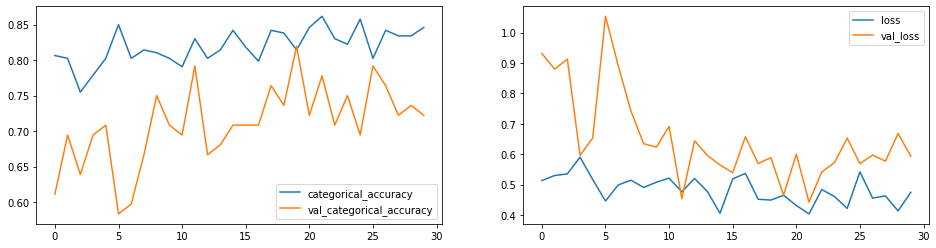

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 12. Model TimeStributed ConvLSTM2D

In [ ]:
input_shape = 18,84,84,3

model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 18, 82, 82, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 18, 82, 82, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 80, 80, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 18, 80, 80, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 78, 78, 8)        

In [ ]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/50


2022-12-12 13:01:49.693013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.4299 - categorical_accuracy: 0.3597Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2022-12-1213_01_04.189524/model-00001-1.42990-0.35968-2.74221-0.18056.h5
11/11 [==============================] - 47s 4s/step - loss: 1.4299 - categorical_accuracy: 0.3597 - val_loss: 2.7422 - val_categorical_accuracy: 0.1806 - lr: 0.0100
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.3178 - categorical_accuracy: 0.4150
Epoch 00002: saving model to model_init_2022-12-1213_01_04.189524/model-00002-1.31776-0.41502-3.19165-0.22222.h5
11/11 [==============================] - 42s 4s/step - loss: 1.3178 - categorical_accuracy: 0.4150 - val_loss: 3.1917 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.3033 - categorical_accuracy: 0.4032
Epoch 00003: saving model to model_init_2022-12-1213_01_04.189524/model-0000

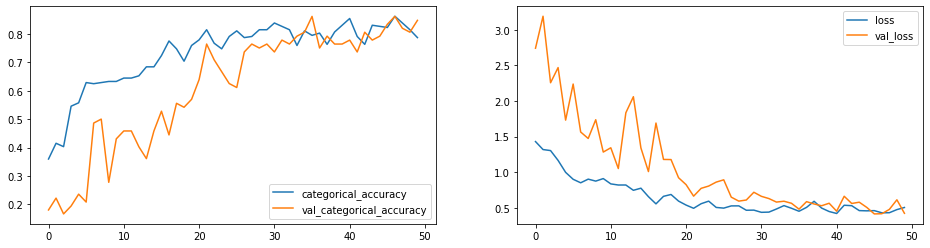

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

### 13. Model Conv3D

In [13]:
# First Model But With More epochs which is 50 and Activation Function Elu
Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [14]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 84, 128)   5

In [15]:
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps= validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 4.8293 - categorical_accuracy: 0.2846Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2022-12-1301_29_53.471139/model-00001-4.82932-0.28458-30.37048-0.19444.h5
11/11 [==============================] - 77s 6s/step - loss: 4.8293 - categorical_accuracy: 0.2846 - val_loss: 30.3705 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 2.8369 - categorical_accuracy: 0.3794
Epoch 2: saving model to model_init_2022-12-1301_29_53.471139/model-00002-2.83691-0.37945-49.96278-0.22222.h5
11/11 [==============================] - 62s 6s/step - loss: 2.8369 - categorical_accuracy: 0.3794 - val_loss: 49.9628 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 2.5473 - categorical_accuracy: 0.4704
Epoch 3:

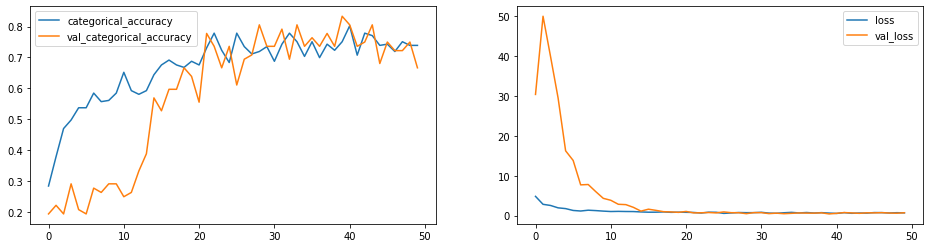

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])